In [1]:
from __future__ import division
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [2]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.


In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [4]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [6]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

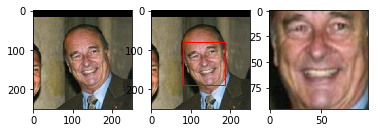

In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [8]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [9]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    print(m)
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

images/Jacques_Chirac/Jacques_Chirac_0020.jpg
images/Jacques_Chirac/Jacques_Chirac_0008.jpg
images/Jacques_Chirac/Jacques_Chirac_0009.jpg
images/Jacques_Chirac/Jacques_Chirac_0019.jpg
images/Jacques_Chirac/Jacques_Chirac_0001.jpg
images/Jacques_Chirac/Jacques_Chirac_0002.jpg
images/Jacques_Chirac/Jacques_Chirac_0003.jpg
images/Jacques_Chirac/Jacques_Chirac_0007.jpg
images/Jacques_Chirac/Jacques_Chirac_0004.jpg
images/Jacques_Chirac/Jacques_Chirac_0005.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0009.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0008.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0001.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0003.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0002.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0006.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0007.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0005.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0004.jpg
images/Gerhard_Schroeder/Gerhard_Schroeder_0010.jpg
images/Vladimir_Puti

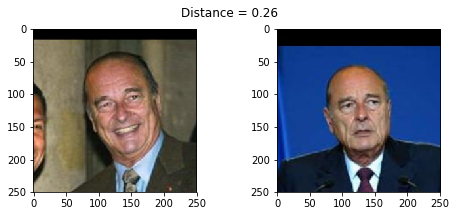

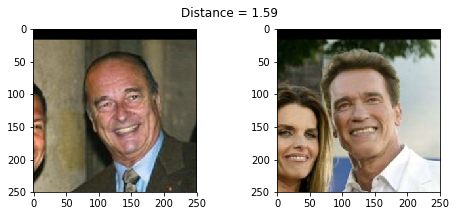

In [10]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 55)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9636363636363636, SVM accuracy = 0.9636363636363636


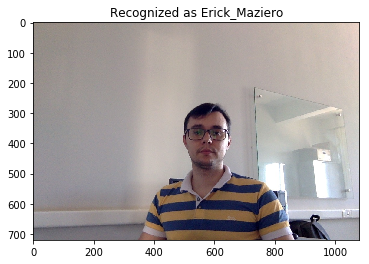

In [13]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 50

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));